In [1]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from camera_intrinsic import get_camera_intrinsics
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


  # Standard Variablen
Hier definieren, extrahieren und verarbeiten wir die Tiefenkarten und RGB-Bilder des Samsung s20+ und des Iphone 14 Pro Max und vergleichen diese miteinander.
Es kann aber hier schon erwähnt werden, dass die Erstellung der Punktewolke und jede weitere Verarbeitung mit den Bildern des Iphone 14 stattfindet, da die Bilder deutlich präziser sind.  

## Tiefenkarte und RGB-Daten extrahieren

IPhone Daten

In [2]:
url_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IphoneTestBilder\IMG_8350.jpg"
output_dir_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten"

rgb_url_Iphone, depth_url_Iphone = transform_jpeg_to_depthmap_iphone(url_Iphone, output_dir_Iphone) #Nutzung unserer Funktion

#Open Images
depth_im_Iphone = Image.open(depth_url_Iphone)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Iphone = Image.open(rgb_url_Iphone)

True
Die Tiefenkarte existiert bereits


Samsung Daten

In [16]:
url_Samsung = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\SamsungTestBilder\20250105_164555.jpg"
output_dir_Samsung = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\SamsungTiefenkarten"

rgb_url_Samsung, depth_url_Samsung = transform_jpeg_to_depthmap_samsungs20(url_Samsung, output_dir_Samsung) #Nutzung unserer Funktion

#Open Images
depth_im_Samsung = Image.open(depth_url_Samsung)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Samsung = Image.open(rgb_url_Samsung)

Die Tiefenkarte existiert bereits


Resize RGB image to size of depthmap

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [17]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height

Resize Iphone RGB Image

In [18]:
rgb_im_Iphone, dm_width_Iphone, dm_height_Iphone = resize(rgb_im_Iphone, depth_im_Iphone)

dm_height:768, dm_width:576
 rgb_height:768, rgb_width:576
new_rgb_height:768, new_rgb_width:576


Resize Samsung RGB Image

In [19]:
rgb_im_Samsung, dm_width_Samsung, dm_height_Samsung = resize(rgb_im_Samsung, depth_im_Samsung)

dm_height:756, dm_width:1008
 rgb_height:3024, rgb_width:4032
new_rgb_height:756, new_rgb_width:1008


Getting the images as numpy arrays for later use

Iphone array

In [20]:
depth_array_Iphone = np.array(depth_im_Iphone)  # getting the depthmap as a numpy array
rgb_array_Iphone = np.array(rgb_im_Iphone)  # getting the rgb image as a numpy array

Samsung array

In [21]:
depth_array_Samsung = np.array(depth_im_Samsung)  # getting the depthmap as a numpy array
rgb_array_Samsung = np.array(rgb_im_Samsung)  # getting the rgb image as a numpy array

We need the images as open3d objects or else we can´t create the RGBD image

Iphone o3d object

In [22]:
# convert the arrays to open3d objects Quelle: https://stackoverflow.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array
rgb_o3d_Iphone = o3d.geometry.Image(rgb_array_Iphone)
depth_o3d_Iphone = o3d.geometry.Image(depth_array_Iphone)
#depth_3d = o3d.geometry.Image(np.ascontiguousarray(depth_array_Iphone))

Samsung o3d object

In [23]:
rgb_o3d_Samsung = o3d.geometry.Image(rgb_array_Samsung)
depth_o3d_Samsung = o3d.geometry.Image(depth_array_Samsung)

# Visualizing depth map

Plotting the Iphone depthmap 

In [24]:
#invertieren des array
depth_array_Iphone = 255 - depth_array_Iphone  # Array umkehren

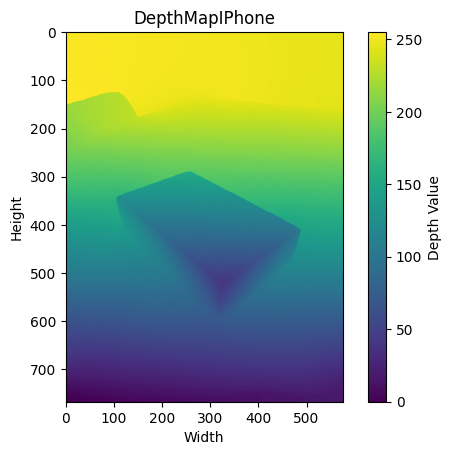

In [26]:
# plotting the depthmap
plt.imshow(depth_array_Iphone)
plt.colorbar(label="Depth Value")
plt.title("DepthMapIPhone")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


Plotting the Samsung depthmap 

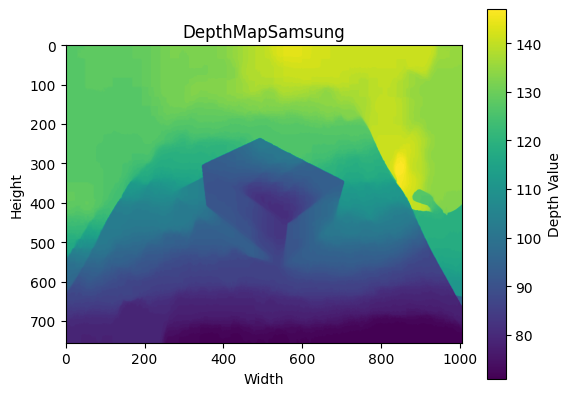

In [27]:
# plotting the depthmap
plt.imshow(depth_array_Samsung)
plt.colorbar(label="Depth Value")
plt.title("DepthMapSamsung")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

 Processing Depth Map

Normalisierung

In [78]:
#depth_array = cv2.normalize(depth_array, None, 0, 255, cv2.NORM_MINMAX)

Filterung

# Create RGBD image

 RGBD Image

In [120]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d_Iphone, depth_o3d_Iphone)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array

Comparison of RGB and depth map image

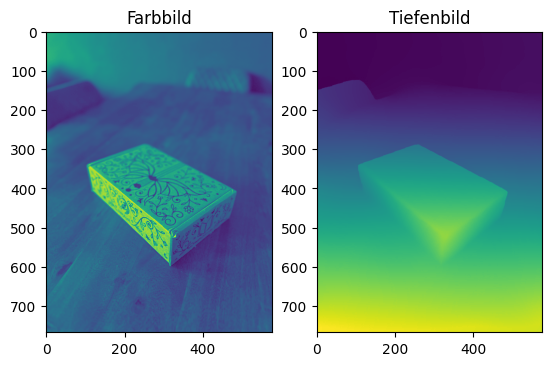

In [121]:
plt.subplot(1, 2, 1)
plt.title("Farbbild")
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title("Tiefenbild")
plt.imshow(rgbd.depth)
plt.show()

# Creating point cloud

## Get camera intrinsics

With the intrinsics of the camera that took the photo we are able to correct distortions 

------------------------------Ab hier versuchen wir die korrekten intrinsics zu erhalten und zu undistorten------------------------------ 

In [122]:
images = glob.glob(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Chesspattern\8x11_normalCamera\*.jpg") #checkerboard pictures for calibration

In [123]:
ret,mtx,dist,rvecs,tvecs, reprojection_error = get_camera_intrinsics(images)

intrinsische Matrix

In [124]:
mtx

array([[2.89474950e+03, 0.00000000e+00, 2.11206867e+03],
       [0.00000000e+00, 2.89795830e+03, 1.57585350e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

because the depthmap image is 768x576 and i can´t calibrate the lidar sensor directly, i will scale the matrix (mtx) and distortion coefficients (dist) of the normal camera down. 

In [125]:
original_width, original_height = 3024, 4032

# sclaingfactor
scale_x = dm_width_Iphone / original_width
scale_y = dm_height_Iphone / original_height

# scaling
scaled_mtx = mtx.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[551.38085675   0.         402.29879443]
 [  0.         551.99205691 300.16257212]
 [  0.           0.           1.        ]]


In [126]:
dist

array([[ 0.23208621, -1.03964089,  0.0066395 ,  0.01134704,  1.25155061]])

In [127]:
# Verzerrungskoeffizienten anpassen
adjusted_dist = dist.copy()
adjusted_dist[0, 2] *= scale_y / scale_x  # p1
adjusted_dist[0, 3] *= scale_x / scale_y  # p2

print("Angepasste Verzerrungskoeffizienten:")
print(adjusted_dist)

Angepasste Verzerrungskoeffizienten:
[[ 0.23208621 -1.03964089  0.0066395   0.01134704  1.25155061]]


In [128]:
#test_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IphoneTestBilder\IMG_8174.jpg"
#------------------Entzerrung------------------
depth_im_Iphone = cv2.imread(depth_url_Iphone)

h,  w = depth_im_Iphone.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))


# undistort
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv2.remap(depth_im_Iphone, mapx, mapy, cv2.INTER_NEAREST)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

In [130]:
dst

array([[[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 14,  14,  14],
        [ 14,  14,  14],
        [ 14,  14,  14]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 14,  14,  14],
        [ 14,  14,  14],
        [ 15,  15,  15]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 15,  15,  15],
        [ 15,  15,  15],
        [ 15,  15,  15]],

       ...,

       [[246, 246, 246],
        [246, 246, 246],
        [247, 247, 247],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [237, 237, 237]],

       [[247, 247, 247],
        [247, 247, 247],
        [247, 247, 247],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [237, 237, 237]],

       [[247, 247, 247],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [237, 237, 237]]

In [134]:
# Extrahieren eines Kanals
depth_array_Iphone_dst = dst[:, :, 0]  # Nur den ersten Kanal verwenden

In [138]:
depth_array_Iphone_dst = 255 - depth_array_Iphone_dst  # Array umkehren

because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

In [90]:
# maximum depth value
D_max = 5.0  # 5 meters
scaling_factor = (D_max / 255.0)
# Umrechnung von Pixelwerten in reale Tiefenwerte
real_depth = depth_array_Iphone_dst * scaling_factor

# Min- und Maxwerte der berechneten Tiefen
print(f"Minimale Tiefe: {np.min(real_depth):.2f} Meter")
print(f"Maximale Tiefe: {np.max(real_depth):.2f} Meter")


Minimale Tiefe: 0.14 Meter
Maximale Tiefe: 4.94 Meter


In [91]:
scaled_array_Iphone = depth_array_Iphone_dst.copy()
scaled_array_Iphone = scaled_array_Iphone * scaling_factor

In [92]:
scaled_array_Iphone

array([[4.94117647, 4.94117647, 4.94117647, ..., 4.7254902 , 4.7254902 ,
        4.7254902 ],
       [4.94117647, 4.94117647, 4.94117647, ..., 4.7254902 , 4.7254902 ,
        4.70588235],
       [4.94117647, 4.94117647, 4.94117647, ..., 4.70588235, 4.70588235,
        4.70588235],
       ...,
       [0.17647059, 0.17647059, 0.15686275, ..., 0.35294118, 0.35294118,
        0.35294118],
       [0.15686275, 0.15686275, 0.15686275, ..., 0.35294118, 0.35294118,
        0.35294118],
       [0.15686275, 0.1372549 , 0.1372549 , ..., 0.35294118, 0.35294118,
        0.35294118]])

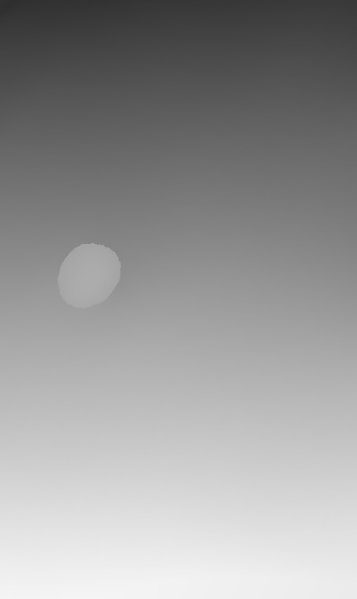

In [93]:
depth_im_Iphone_test = Image.open(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\calibresultdepth.png")
depth_im_Iphone_test

In [94]:
depth_array_Iphone_undis = np.array(depth_im_Iphone_test)  # getting the depthmap as a numpy array #test

In [95]:
depth_array_Iphone_undis.min()

46

In [96]:
# Extrahieren eines Kanals
depth_array_Iphone_undis = depth_array_Iphone_undis[:, :, 0]  # Nur den ersten Kanal verwenden

In [97]:
depth_array_Iphone_undis.shape

(599, 357)

In [98]:
depth_array_Iphone.shape

(768, 576)

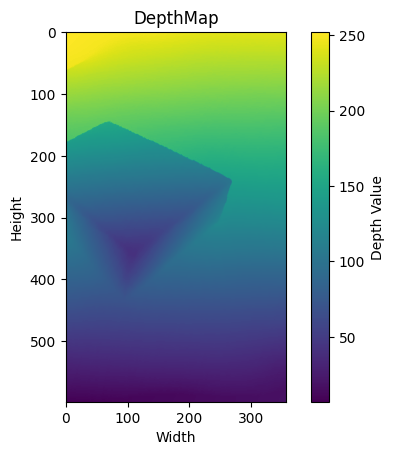

In [139]:
# plotting the depthmap #test
plt.imshow(depth_array_Iphone_dst, cmap='viridis')  # Viridis ist eine gut sichtbare Colormap
plt.colorbar(label="Depth Value")
plt.title("DepthMap")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

In [100]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_2 = o3d.camera.PinholeCameraIntrinsic(width=357,height=599, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 551.3808567503123, fy: 551.9920569077799, cx: 402.2987944260262, cy: 300.1625721234666


In [136]:
depth_data_uint16_Iphone = (depth_array_Iphone_dst.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

In [137]:

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

# Punktwolke aus Tiefenkarte erstellen
point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic=intrinsic_2
    #depth_scale=1000.0,  # Skalierungsfaktor für Millimeter
    #depth_trunc=1000.0,  # Maximale Tiefe in Millimetern
)

# Punktwolke visualisieren
o3d.visualization.draw_geometries([point_cloud])


------------------------------Hier ist das Ende der korrekten intrinsics und  undistorten------------------------------ 


In [103]:
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    dm_width_Iphone, 
    dm_height_Iphone, 
    fx,  # Fokuslänge x
    fy,  # Fokuslänge y
    cx,  # optisches Zentrum x
    cy   # optisches Zentrum y
)

In [104]:
#iphone daten aus exif

#extrinsics
extrinsics = np.array([
    [0.0, -1.0, 0.0, 0.0],
    [1.0,  0.0, 0.0, 0.0],
    [0.0,  0.0, 1.0, 0.0],
    [0.0,  0.0, 0.0, 1.0]
])

# Kamera-Parameter-intrinsic
dm_width_Iphone  # Intrinsic Matrix Reference Width
dm_height_Iphone  # Intrinsic Matrix Reference Height
fx = 2855.5684  # Fokallänge in Pixeln entlang x
fy = 2855.5684  # Fokallänge in Pixeln entlang y
cx = 1515.6122  # Principal Point x
cy = 2022.2196  # Principal Point y

# Anpassung der intrinsischen Parameter an die Tiefenkarte
scale_x = dm_width_Iphone / 3024  # Verhältnis zur Referenzbreite
scale_y = dm_height_Iphone / 4032  # Verhältnis zur Referenzhöhe

fx_scaled = fx * scale_x  # Skalierte Fokallänge x
fy_scaled = fy * scale_y  # Skalierte Fokallänge y
cx_scaled = cx * scale_x  # Skalierter Hauptpunkt x
cy_scaled = cy * scale_y  # Skalierter Hauptpunkt y


# Intrinsic Matrix als Open3D-Objekt
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=dm_width_Iphone,height=dm_height_Iphone, fx=fx_scaled, fy=fy_scaled, cx=cx_scaled, cy=cy_scaled)

## Point cloud only from depth image

PCD Iphone

In [105]:

# # Erstellen der PinholeCameraIntrinsic für das Bild 768x576
# intrinsics = o3d.camera.PinholeCameraIntrinsic(
#     width=768,
#     height=576,
#     fx=550.0,  # Brennweite in x-Richtung
#     fy=550.0,  # Brennweite in y-Richtung
#     cx=384.0,  # Optisches Zentrum in x
#     cy=288.0   # Optisches Zentrum in y
# )

In [142]:
#test für die intrinsiche operation

depth_data_uint16_Iphone = (depth_array_Iphone_dst.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Point Cloud aus der Tiefenkarte
pcd_Iphone = o3d.geometry.PointCloud.create_from_depth_image(
    depth_uint16_o3d_Iphone,
    intrinsic,
)

# Extrinsische Matrix anwenden
#pcd_Iphone.transform(extrinsics)

In [144]:
o3d.visualization.draw_geometries([pcd_Iphone])

PCD Samsung

In [47]:
#depth image von uint8 zu uint16, da sonst die Funktion "o3d.geometry.PointCloud.create_from_depth_image" nicht funktioniert. Quelle: https://www.open3d.org/docs/latest/python_api/open3d.geometry.PointCloud.html
depth_data_uint16_Samsung = (depth_array_Samsung.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Samsung = o3d.geometry.Image(depth_data_uint16_Samsung)

# Erstelle eine Point Cloud aus dem Tiefenbild
pcd_Samsung = o3d.geometry.PointCloud.create_from_depth_image(
    depth_uint16_o3d_Samsung,
    intrinsic
)

In [48]:
#o3d.visualization.draw_geometries([pcd_Samsung])

## Point cloud only from RGBD image

In [49]:
pcrgbd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
o3d.visualization.draw_geometries([pcrgbd])

# Clean Point Cloud

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [50]:
pcd_center = pcd_Iphone.get_center()
pcd_Iphone.translate(pcd_center)

PointCloud with 442249 points.

In [51]:
pcd_center = pcd_Samsung.get_center()
pcd_Samsung.translate(pcd_center)

PointCloud with 762048 points.

## Voxelization

In [52]:
#pcd_Iphone = pcd_Iphone.voxel_down_sample(voxel_size=0.0000005)
#o3d.visualization.draw_geometries([pcd_Iphone])

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [53]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [54]:
cl, ind = pcd_Iphone.remove_statistical_outlier(nb_neighbors=100, std_ratio=3.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [55]:
display_inlier_outlier(pcd_Iphone, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [56]:
# Cleaned PC
pcd_Iphone = pcd_Iphone.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [57]:
#o3d.visualization.draw_geometries([pcd_Iphone])

## Estimating normals

In [58]:
nn_distance = np.mean(pcd_Iphone.compute_nearest_neighbor_distance())

print(nn_distance)

0.00026101732165251257


In [59]:
radius_normals = nn_distance * 4

pcd_Iphone.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd_Iphone.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([pcd_Iphone])

## Multi RANSAC

In [60]:
front = [ -0.26316981750620544, 0.40283907551778914, 0.87661983002309707 ]
lookat = [ -0.11224615038136918, -0.0060122200969514247, 0.24006176520010536 ]
up = [ 0.75550742721619912, 0.65112664204123394, -0.072405962774251584 ]
zoom = 0.69999999999999996

In [61]:
pt_to_plane_dist = 0.028

plane_model, inliers = pcd_Iphone.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=20, num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd_Iphone.select_by_index(inliers)
outlier_cloud = pcd_Iphone.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], zoom=zoom, front=front, lookat=lookat, up=up)


Plane equation: -0.04x + 0.89y + 0.45z + -0.12 = 0


In [62]:
max_plane_idx = 6
pt_to_plane_dist = 0.02

segment_models = {}
segments = {}
rest = pcd_Iphone

for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=pt_to_plane_dist, ransac_n=3, num_iterations=1000)
    segments[i] = rest.select_by_index(inliers)
    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert=True)
    print("pass", i, "/", max_plane_idx, "done.")

o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)] + [rest], zoom=zoom, front=front, lookat=lookat, up=up)


pass 0 / 6 done.
pass 1 / 6 done.
pass 2 / 6 done.
pass 3 / 6 done.


RuntimeError: [Open3D Error] (class std::tuple<class Eigen::Matrix<double,4,1,0,4,1>,class std::vector<unsigned __int64,class std::allocator<unsigned __int64> > > __cdecl open3d::geometry::PointCloud::SegmentPlane(const double,const int,const int,const double) const) D:\a\Open3D\Open3D\cpp\open3d\geometry\PointCloudSegmentation.cpp:175: There must be at least 'ransac_n' points.


## Plane segmentation with RANSAC

In [ ]:
plane_model, inliers = pcd_Iphone.segment_plane(
    distance_threshold=0.0285,
    ransac_n=10,
    num_iterations=6000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
inlier_cloud = pcd_Iphone.select_by_index(inliers)
inlier_cloud = inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd_Iphone.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
o3d.visualization.draw_geometries(
    [inlier_cloud, outlier_cloud])


In [ ]:
pcd_Iphone = outlier_cloud

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone], window_name="")

## SOR again

In [ ]:
#ggf. kann man für die restlichen punkte nun wieder SOR nutzen?
cl, ind = pcd_Iphone.remove_statistical_outlier(nb_neighbors=1000, std_ratio=3.0) 

In [ ]:
display_inlier_outlier(pcd_Iphone, ind)

In [ ]:
# Cleaned PC
pcd_Iphone = pcd_Iphone.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone])

## Hidden point removal

# Sonstiges/Tests

## Entzerrung

In [ ]:
depth_image = cv2.imread(url, cv2.IMREAD_UNCHANGED)

if depth_image is None:
    raise ValueError("Tiefenkarte konnte nicht geladen werden.")
if depth_image.dtype != np.uint16:
    print("Tiefenkarte ist nicht im 16-Bit-Format. Konvertiere...")
    if depth_image.dtype == np.uint8:
        depth_image = (depth_image.astype(np.uint16)) * 256  # Skalieren, falls 8-Bit
    else:
        raise ValueError(f"Unsupported depth image dtype: {depth_image.dtype}")

intrinsic_matrix = np.array([
    [fx_scaled, 0, cx_scaled],
    [0, fy_scaled, cy_scaled],
    [0, 0, 1]
])

# undisort coeffs from exif data
distortion_coeffs = np.array([
    0.0,  # k1
    -0.1,  # k2 (reduziert)
    0.0,  # p1
    0.0,  # p2
    0.0   # k3
])

# undistort depthmap
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
    intrinsic_matrix,
    distortion_coeffs,
    (dm_width_Iphone, dm_height_Iphone),
    alpha=1  # 1: Behalte alle Pixel
)

undistorted_depth = cv2.undistort(
    depth_image,
    intrinsic_matrix,
    distortion_coeffs,
    None
)

depth_image_o3d = o3d.geometry.Image(undistorted_depth)

intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=dm_width_Iphone,
    height=dm_height_Iphone,
    fx=new_camera_matrix[0, 0],  # Angepasste Fokallänge x
    fy=new_camera_matrix[1, 1],  # Angepasste Fokallänge y
    cx=new_camera_matrix[0, 2],  # Angepasster Hauptpunkt x
    cy=new_camera_matrix[1, 2]   # Angepasster Hauptpunkt y
)

pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image_o3d,
    intrinsics,
    depth_scale=1000.0,  # Skala für Tiefenwerte (z.B. mm -> Meter)
    project_valid_depth_only=True
)

pcd.transform(extrinsics)

o3d.visualization.draw_geometries([pcd])


In [ ]:
# cv2.imshow("Original Depth Map", depth_image)
# cv2.imshow("Undistorted Depth Map", undistorted_depth)
# cv2.waitKey(0)

## DBSCAN-Clustering

In [ ]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_Iphone.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd_Iphone.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd_Iphone])

In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  # Ersetzen Sie dies durch die Cluster-ID des unerwünschten Clusters

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne das unerwünschte Cluster erstellen
remaining_cloud = pcd_Iphone.select_by_index(indices_to_remove, invert=True)

# Visualisierung der bereinigten Punktwolke
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")


## Convex Hull
Die Konvexe Hülle wird ggf. relevant für die Volumenberechnung, sobald ich nur das Zielobjekt extrahieren kann. Problem ist nur bei dieser Methode, dass bspw. runde Objekte überschätzt werden. 

In [ ]:
scale_factor = 1000  # Skalieren um den Faktor 1000 (z. B. mm -> m)
remaining_cloud.scale(scale_factor, center=remaining_cloud.get_center())

In [ ]:
# calculate hull
hull_mesh, hull_vertices = remaining_cloud.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([remaining_cloud, hull_ls])


In [ ]:
# Konvexe Hülle aus der Punktwolke berechnen
hull, _ = remaining_cloud.compute_convex_hull()

#Volumen der konvexen Hülle berechnen
volume = hull.get_volume()

print(f"Volumen der konvexen Hülle: {volume:.2f} Einheiten^3")

In [ ]:
bounds = remaining_cloud.get_max_bound() - remaining_cloud.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.2f}, y={bounds[1]:.2f}, z={bounds[2]:.2f}")


In [ ]:
print(f"Anzahl der Punkte in der konvexen Hülle: {len(hull.vertices)}")
print(f"Anzahl der Dreiecke in der konvexen Hülle: {len(hull.triangles)}")


In [ ]:
# Visualisierung der Hülle und Punktwolke
hull.paint_uniform_color([1, 0, 0])  # Hülle rot färben
o3d.visualization.draw_geometries([remaining_cloud, hull])

## Mesh
Ggf. auch interessant

## Interaktive PC

In [ ]:
# Punktwolke interaktiv anzeigen
print("Drücke 'Shift + Linksklick', um Punkte auszuwählen, und 'Shift + Rechtsklick', um Auswahl aufzuheben.")
picked_points = o3d.visualization.draw_geometries_with_editing([pcd])

# Ausgewählte Punkt-Indizes anzeigen
print(f"Ausgewählte Punkt-Indizes: {picked_points}")

In [ ]:
print(picked_points)

In [ ]:
import numpy as np

# Koordinaten der Punkte
point1 = np.array([-0.12, 0.0076, 0.24])  # Punkt 1 (#250552)
point2 = np.array([-0.034, -0.071, 0.16])  # Punkt 2 (#52765)

# Euklidische Distanz berechnen
distance = np.linalg.norm(point2 - point1)

# Ergebnis ausgeben
print(f"Abstand zwischen den Punkten: {distance:.6f} Einheiten")


weiteres

In [ ]:
# Punktkoordinaten abrufen
points = np.asarray(pcd_Iphone.points)

# Minimum und Maximum der Z-Achse (Tiefe) prüfen
min_z = np.min(points[:, 2])
max_z = np.max(points[:, 2])

print(f"Minimale Z-Tiefe: {min_z}")
print(f"Maximale Z-Tiefe: {max_z}")

In [ ]:
# unit of measurement herausfinden
depth_array_Iphone